## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [14]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
# %matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Image Size
shape_y = 720
shape_x = 1280

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Create folder to save calibration outputs
dir_output_cal = 'output_cal'
if not os.path.exists(dir_output_cal):
    os.mkdir(dir_output_cal)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    cv2.resize(img, (shape_y, shape_x))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite(os.path.join(dir_output_cal,fname.split('/')[-1]),img)
        # cv2.waitKey(500)

# cv2.destroyAllWindows()

# Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (shape_y, shape_x), None, None)

# Create folder to hold undistort images
dir_output_undist = 'output_undist'
if not os.path.exists(dir_output_undist):
    os.mkdir(dir_output_undist)
# Generate undistort images to verify
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, None)
    cv2.imwrite(os.path.join(dir_output_undist,fname.split('/')[-1]), dst)

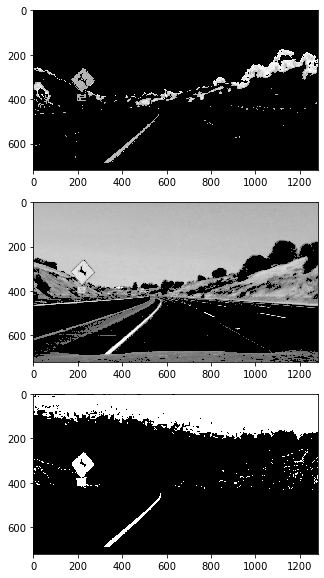

In [244]:
img = cv2.imread('./test_images/test2.jpg')
# img = cv2.imread('./data/frame1040.jpg')
# dst = cv2.undistort(img, mtx, dist, None, None)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h = hsv[:,:,0]
v = hsv[:,:,2]
s = hsv[:,:,1]
s[s<120]=0
v[v<100] = 0
h[(h<20) | (h>30)] = 0
blank = np.zeros_like(s)
blank[(s != 0) & (v != 0)] = 255
plt.subplots(3,1,figsize=(20,10))
plt.subplot(311)
plt.imshow(h, cmap='gray')
plt.subplot(312)
plt.imshow(v, cmap="gray")
plt.subplot(313)
plt.imshow(blank, cmap="gray")

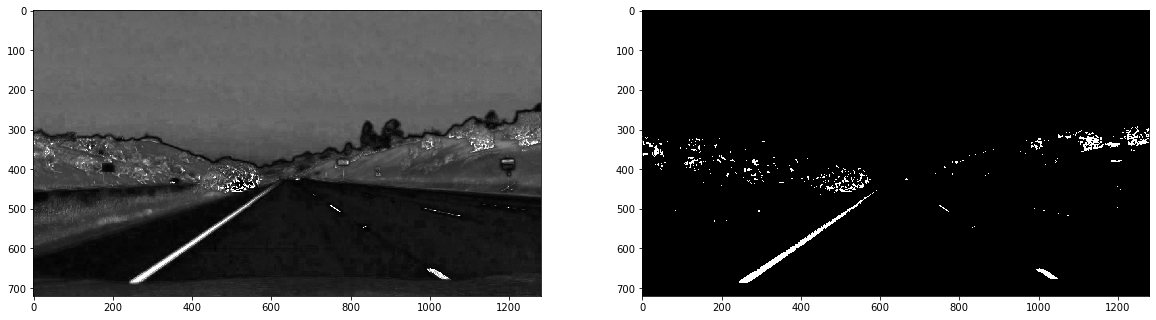

In [476]:
def hls_select_with_s(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    l = hls[:,:,1]
    bin_img = np.zeros_like(s)
    # bin_img[(thresh[0] < l) & (l <= thresh[1])] = 1
    bin_img[(thresh[0] < s) & (s <= thresh[1])] = 1
    return s, bin_img

def hls_select(img, thresh=(0,255)):
    s, bin_img = hls_select_with_s(img, thresh)
    return bin_img

# img = cv2.imread('./data/frame1040.jpg')
img = cv2.imread('./test_images/straight_lines1.jpg')
dst = cv2.undistort(img, mtx, dist, None, None)

s, bin_img = hls_select_with_s(img, (120,255))
plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
plt.imshow(s, cmap='gray')
plt.subplot(122)
plt.imshow(bin_img, cmap="gray")


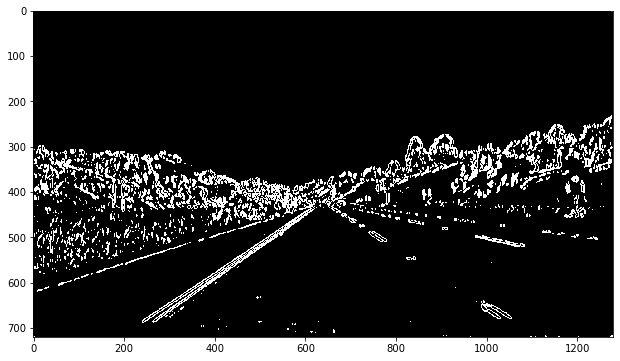

In [477]:
def sobel_1Dselect(img, axis='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.absolute(sobel)/np.max(sobel)*255
    bin_img = np.zeros_like(gray)
    bin_img[(sobel > thresh[0]) & (sobel <= thresh[1])] = 1
    return bin_img

bin_img = sobel_1Dselect(img,'x', 15, (20,100))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

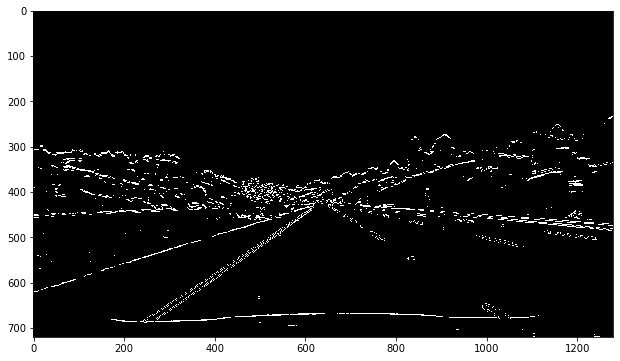

In [478]:
bin_img = sobel_1Dselect(img,'y', 7, (50,100))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

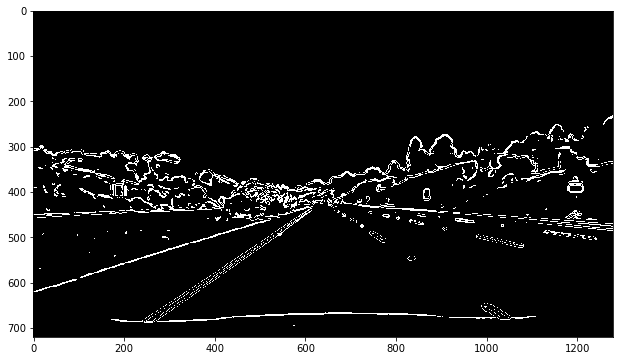

In [479]:
def sobel_mag_select(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    abs_sobel = (abs_sobel/np.max(abs_sobel)*255).astype(np.uint8)
    bin_img = np.zeros_like(gray)
    bin_img[(abs_sobel > thresh[0]) & (abs_sobel <= thresh[1])] = 1
    return bin_img

bin_img = sobel_mag_select(img, 15, (50,100))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")
    

(720, 1280, 3)


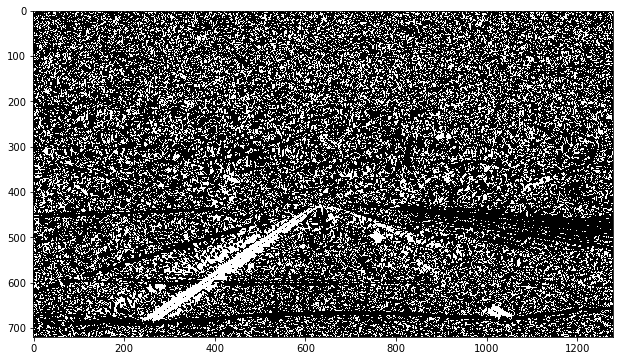

In [480]:
def sobel_dir_select(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_angle = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    bin_img = np.zeros_like(gray)
    bin_img[(sobel_angle > thresh[0]) & (sobel_angle <= thresh[1])] = 1
    return bin_img

bin_img = sobel_dir_select(img, 21, (0.8,1.2))
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img*255, cmap="gray")
print(img.shape)

## And so on and so forth...

(720, 1280) (720, 1280) (720, 1280)


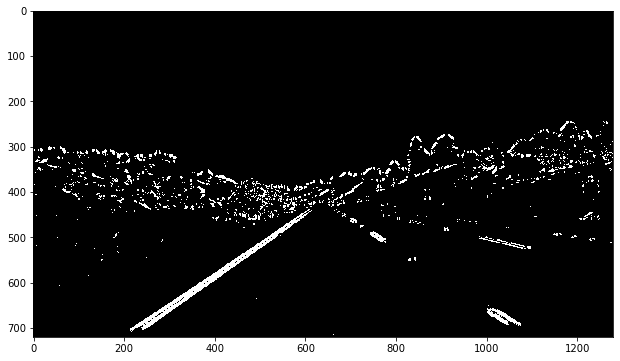

In [481]:
undist = cv2.undistort(img, mtx, dist, None, None)
bin_dir = sobel_dir_select(undist, 15, (0.8,1.2))
bin_mag = sobel_mag_select(undist,15,(50,255))
bin_s = hls_select(undist, thresh=(120,255))
bin_sobelx = sobel_1Dselect(undist,'x',15,(30,255))
bin_sobely = sobel_1Dselect(undist,'y',15,(30,255))
bin_img = np.zeros_like(gray)
bin_img[(bin_dir == 1) & (bin_mag == 1)] = 1
print(bin_sobelx.shape, bin_sobely.shape, bin_s.shape)
# combined = (bin_mag & bin_dir)|(bin_sobely&bin_sobelx) |(bin_s & (bin_sobelx&bin_sobely & bin_dir))
combined = (bin_sobely&bin_sobelx) |(bin_s & bin_dir)
color_binary = np.dstack(( combined,combined,combined )) * 255
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(color_binary, cmap="gray")

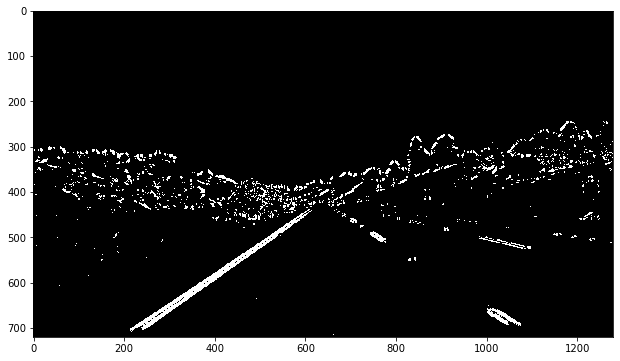

In [482]:
# bin_img = ((bin_sobely&bin_sobelx) |(bin_s & (bin_sobelx&bin_sobely & bin_dir)))*255
# bin_img = (bin_s | (bin_sobelx&bin_sobely & bin_dir))*255
bin_img = combined*255
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(bin_img, cmap="gray")

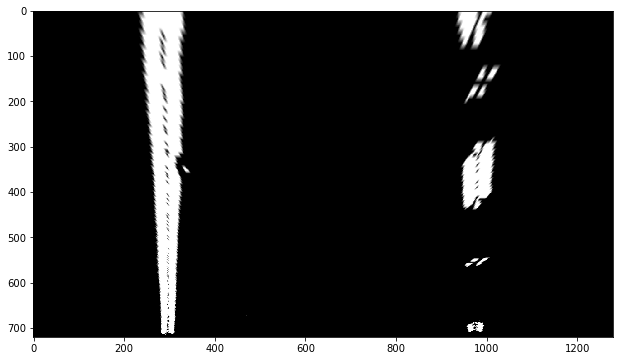

In [493]:

margin = 300
# src = np.float32([[(595,450),(690,450),(1108,719),(210, 719)]])
src = np.float32([[(578,465),(707,465),(1108,719),(210, 719)]])
dst = np.float32([(margin,0),(1280-margin,0),(1280-margin,719),(margin,719)])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(bin_img, M, (1280,720), flags=cv2.INTER_LINEAR)
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(warped, cmap="gray")


287 982


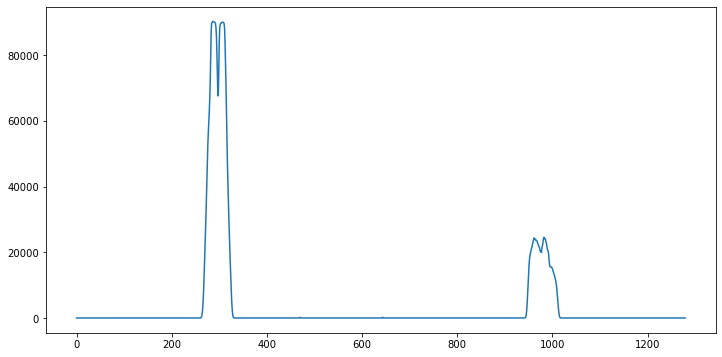

In [494]:
#warped as input image
def hist(warped_img):
    """warped_img a binary image after perspective transformation"""
    bottom_half = warped[warped.shape[0]//2:, :]
    return np.sum(bottom_half, axis=0)

histogram = hist(warped)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(histogram)

#find the starting point of left/right lanes
mid_point = len(histogram)//2
left_x_base = np.argmax(histogram[:mid_point])
right_x_base = np.argmax(histogram[mid_point:]) + mid_point
print(left_x_base, right_x_base)

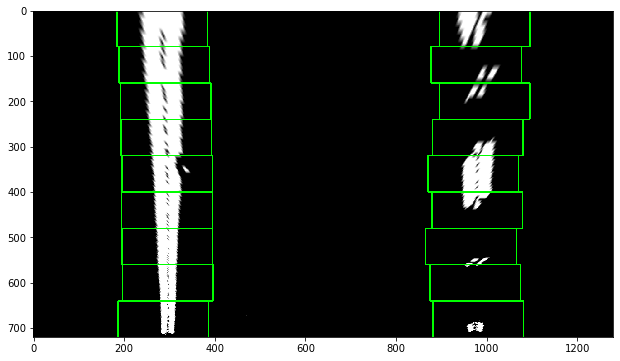

In [495]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(out_img)

In [502]:
def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):
    """
    Calculates the curvature of polynomial functions in meters.
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 550/ym_per_pix
    left_fit_real = [xm_per_pix*left_fit_cr[0]/(ym_per_pix**2), xm_per_pix*left_fit_cr[1]/ym_per_pix, left_fit_cr[2]*xm_per_pix]
    right_fit_real = [xm_per_pix*right_fit_cr[0]/(ym_per_pix**2), xm_per_pix*right_fit_cr[1]/ym_per_pix, right_fit_cr[2]*xm_per_pix]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_real[0]*y_eval*ym_per_pix + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0])
    right_curverad = ((1 + (2*right_fit_real[0]*y_eval*ym_per_pix + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0])
    # left_curverad = ((1 + ((2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1]*ym_per_pix)**2)/xm_per_pix)**1.5) / np.absolute(2*left_fit_cr[0]/xm_per_pix)
    # right_curverad = ((1 + ((2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1]*ym_per_pix)/xm_per_pix)**2)**1.5) / np.absolute(2*right_fit_cr[0]/xm_per_pix)
    
    return left_curverad, right_curverad

2389.1665508466886 1407.13410555239
0.10699649791351401 3.5888139418616483
<class 'numpy.int32'>


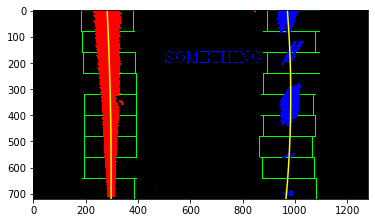

In [503]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty)
    print(left_curverad, right_curverad)
    # print(left_curverad, right_curverad)
    check_parallel(left_fit, right_fit, ploty)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # cv2.polylines(out_img, np.vstack((left_fitx, ploty)).T.astype("uint32"), False, color=[255, 0, 255])
    # cv2.polylines(out_img, np.vstack((right_fitx, ploty)).T.astype("uint32"), False, color=[255, 0, 255])
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    cv2.polylines(out_img, np.array([[[847,0],[848,1],[848,2]]]), isClosed=False, color=[255,0,255], thickness=10)
    print(type(np.array([[[847,0],[848,1],[848,2]]])[0][0][0]))

    return out_img

out_img = fit_polynomial(warped)
text = 'SOMETHING'
cv2.putText(out_img, text, (500, 200), cv2.FONT_HERSHEY_COMPLEX, 2, [0,0,255])
plt.imshow(out_img)
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.imshow(out_img)

In [498]:
def check_parallel(left_fit, right_fit, ploty):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension\

    y_max = np.max(ploty)
    y_min = np.min(ploty)
    # Calculate distance at the top
    left_fitx = left_fit[0]*y_min**2 + left_fit[1]*y_min + left_fit[2]
    right_fitx = right_fit[0]*y_min**2 + right_fit[1]*y_min + right_fit[2]
    dist_top = right_fitx - left_fitx
    # Calculate distance at the bottom
    left_fitx = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_fitx = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    dist_bot = right_fitx - left_fitx
    dist_avg = np.mean([dist_bot, dist_top])
    print(np.absolute((dist_top - dist_bot)*xm_per_pix), dist_avg*xm_per_pix)
    # if np.absolute((dist_top - dist_bot)*xm_per_pix) < 

In [499]:
from adv_lane_finding import *
left_lane = Line()
right_lane = Line()
myLaneFinding = LaneFinding(Camera('camera_cal','output_cal'), left_lane, right_lane)

In [500]:
result = myLaneFinding.process_image(img)
myLaneFinding.left_lane.best_curvature
myLaneFinding.right_lane.best_curvature

TypeError: 'NoneType' object is not subscriptable